In [1]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from silentsub.silentsub import SilentSubstitutionDevice
from silentsub.plotting import stim_plot
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


Load the data with `StimulationDevice`
--------------------------------------

basinhopping step 0: f 0.756246


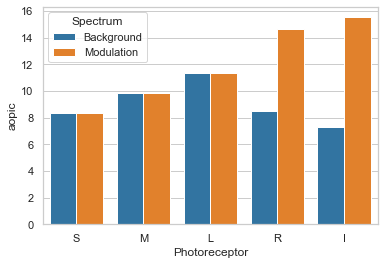

basinhopping step 1: f 0.583788 trial_f 0.583788 accepted 1  lowest_f 0.583788
found new global minimum on step 1 with function value 0.583788


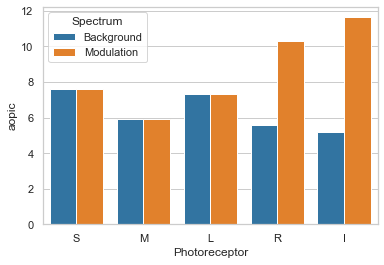

basinhopping step 2: f 0.0188653 trial_f 0.0188653 accepted 1  lowest_f 0.0188653
found new global minimum on step 2 with function value 0.0188653


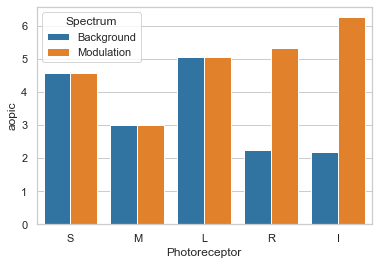

In [2]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# List of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# Instantiate the class / define the problem
ss = SilentSubstitutionDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1,
    ignore=['R'],
    silence=['S', 'M', 'L'],
    isolate=['I'],
    background=None,
    bounds=None,
)

# Find a solution
result = ss.find_modulation_spectra(
    target_contrast=2.,
    tollerance=.1
)

<AxesSubplot:>

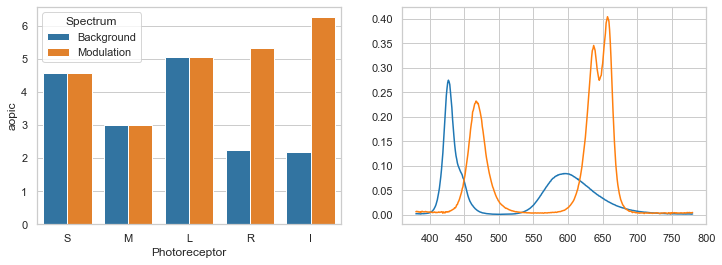

In [3]:
def plot_solution(background, modulation, ax=None):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum', ax=ax)
    
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bg_ao = ss.predict_multiprimary_aopic(result.x[0:10], name='Background')
mod_ao = ss.predict_multiprimary_aopic(result.x[10:20], name='Modulation')

bg_spd = ss.predict_multiprimary_spd(result.x[0:10], name='Background')
mod_spd = ss.predict_multiprimary_spd(result.x[10:20], name='Modulation')

plot_solution(bg_ao.T.squeeze(), mod_ao.T.squeeze(), ax=axs[0])

bg_spd.T.plot(ax=axs[1])
mod_spd.T.plot(ax=axs[1])

Find contrast gradient
----------------------

In [4]:
bg = result.x[0:10]
mod = result.x[10:20]
new_bounds = [(min(val), max(val)) for val in zip(bg, mod)]
new_bounds

[(2.8404976650011848e-17, 0.71806192047727313),
 (2.8051613712550043e-18, 0.10170139647473221),
 (7.9233536958191791e-17, 0.22271131405289052),
 (7.9987607826474705e-18, 0.55580404005982254),
 (8.5693133860295631e-17, 0.013564893590435945),
 (1.0997218809891992e-16, 0.00042083951872091887),
 (1.3706920627932529e-17, 0.0020200248631468032),
 (0.003765501209589362, 0.30034801504133796),
 (3.4682747942062018e-17, 0.9523641861313703),
 (1.3929951263653001e-16, 0.8175582689019083)]

In [16]:
from scipy.optimize import minimize

# Set the background spectrum
ss.set_background(bg)

# Linear contrast gradient (for now)
contrast_gradient = np.linspace(2, 0, 10)

# Constraints for SLSQP
constraints = {
    'type': 'eq',
    'fun': lambda x: ss._silencing_constraint(x)
}

# List for solutions
solutions = {}

# We don't need the first and last as these are the original 
# background and modulation spectra
for i, target_contrast in enumerate(contrast_gradient[1:-1]):  
    if i==0:
        x0 = mod
    else:
        x0 = r.x
    print(f'Target contrast: {target_contrast}') 
    
    r = minimize(
        fun=ss._isolation_objective,
        x0=x0,
        args=(target_contrast),
        method='SLSQP',
        jac=None,
        hess=None,
        hessp=None,
        bounds=new_bounds,
        constraints=constraints,
        tol=.0000001,
        callback=None,
        options={'maxiter': 500, 'disp': True},
    )
    
    solutions[i] = r

Target contrast: 1.7777777777777777
Optimization terminated successfully    (Exit mode 0)
            Current function value: [  1.05355524e-09]
            Iterations: 56
            Function evaluations: 757
            Gradient evaluations: 56
Target contrast: 1.5555555555555556
Optimization terminated successfully    (Exit mode 0)
            Current function value: [ 0.17789538]
            Iterations: 84
            Function evaluations: 1506
            Gradient evaluations: 84
Target contrast: 1.3333333333333335
Optimization terminated successfully    (Exit mode 0)
            Current function value: [  7.91935757e-08]
            Iterations: 24
            Function evaluations: 316
            Gradient evaluations: 24
Target contrast: 1.1111111111111112
Optimization terminated successfully    (Exit mode 0)
            Current function value: [  3.11122208e-08]
            Iterations: 16
            Function evaluations: 221
            Gradient evaluations: 16
Target contrast:

Solution: 0
Solution: 1
Solution: 2
Solution: 3
Solution: 4
Solution: 5
Solution: 6
Solution: 7


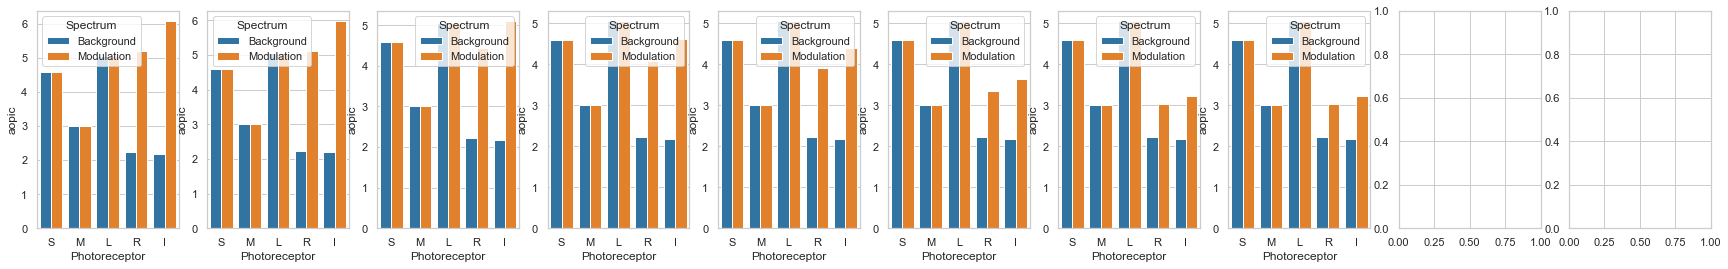

In [25]:
fig, axs = plt.subplots(1, len(solutions)+2, figsize=(30, 4))

for i in solutions.keys():
    print(f'Solution: {i}')
    b, m = ss.smlri_calculator(solutions[i]['x'])
    plot_solution(b, m, ax=axs[i])


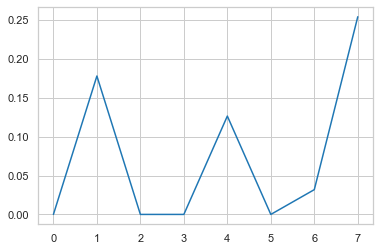

In [21]:
plt.plot([solutions[key]['fun'] for key in solutions.keys()])

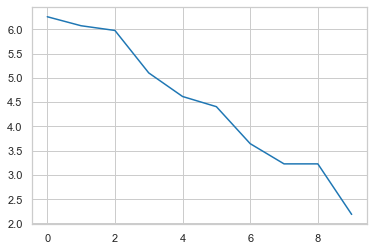

In [22]:
plt.plot([mod_ao['I']] + [ss.predict_multiprimary_aopic(solutions[key]['x'])['I'] for key in solutions.keys()] + [bg_ao['I']])